In [1]:
# This code block configures things for google colab
! pip install git+https://github.com/shchurch/countland.git\#egg=countland\&subdirectory=countland-py
! git clone https://github.com/shchurch/countland.git
! pip install scipy==1.7.3

  Cloning https://github.com/shchurch/countland.git to /private/var/folders/tq/3qjvbb7j0_vg8ksxzrsmwlk80000gn/T/pip-install-7o1zk1lj/countland_10a678f791524b5eb65099c1e4f4d9cf
  Running command git clone --filter=blob:none --quiet https://github.com/shchurch/countland.git /private/var/folders/tq/3qjvbb7j0_vg8ksxzrsmwlk80000gn/T/pip-install-7o1zk1lj/countland_10a678f791524b5eb65099c1e4f4d9cf
  Resolved https://github.com/shchurch/countland.git to commit d9e34a83b191dbfb35209861fe0926697d71c3dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/shchurch/integer_matrix_approximation.git to /private/var/folders/tq/3qjvbb7j0_vg8ksxzrsmwlk80000gn/T/pip-install-7o1zk1lj/ima_620c275be3a44d6f8b30ca3eddb6084e
  Running command git clone --filter=blob:none --quiet https://github.com/shchurch/integer_matrix_approximation.git /private/var/folders/tq/3qjvbb7j0_vg8ksxzrsmwlk80000gn/T/pip-i

  Attempting uninstall: scipy
    Found existing installation: scipy 1.8.1
    Uninstalling scipy-1.8.1:
      Successfully uninstalled scipy-1.8.1


**note: in google colab, you must restart the runtime after running the above block**

# countland: python tutorial
**Samuel H. Church, Casey W. Dunn**

This tutorial demonstrates the major functions of `countland` by applying them to a Gold standard single-cell RNA sequencing dataset from [Freytag _et al_ (2018)](10.12688/f1000research.15809.2).

`countland` is a **barebones** set of functions for applying a restricted linear algebra to the analysis of count-based data. As such, there are many opportunities for further optimization that may prove useful in the anlaysis of your own data. We provide the source code freely available at https://github.com/shchurch/countland and encourage users and developers to fork the code for their own purposes.

The following packages are required to complete the tutorial.

In [2]:
import countland
import scanpy as sc
import numpy as np

import os
if 'google.colab' in str(get_ipython()):
  os.chdir("countland/countland-py/vignettes/")

import matplotlib
matplotlib.pyplot.style.use('classic')
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Get the data

We have used the Gold standard dataset provided by [Freytag _et al_ (2018)](10.12688/f1000research.15809.2). This data consists of ~1000 cells that have ground truth labels corresponding to three human lung cell lines.

`countland` accepts an AnnData object (as does `scanpy`). 

In [3]:
adata = sc.read_10x_mtx(
    "../../data/Gold_Freytag2018",  # the directory with the `.mtx` file
    var_names='gene_symbols',    # use gene symbols for the variable names (variables-axis index)
    cache=True)                  # write a cache file for faster subsequent reading

adata.var_names_make_unique()    # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

## Initialize `countland` object

First we construct an instance of a `countland` object, loading it with the data from the AnnData object.

In [4]:
C = countland.countland(adata)
print(C)

initializing countland object...
removing empty cells and genes...

        countland object
        Count matrix has 925 cells (rows)
         and 29212 genes (columns)
        The fraction of entries that are nonzero is 0.2905
        


The count matrix is stored in `C.counts`

In [5]:
C.counts

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  6,  1,  0],
       [ 0,  0,  0, ..., 12,  2,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  1,  0]])

Note that most counts are zero for scRNA-seq data.

## Summarize counts across cells and genes

We can explore our data by checking the total number of counts and other expression measures per cell and per gene.

Expression measures include: 
- total counts
- maximum number of counts observed across genes
- number of genes with observed counts
- number of genes with counts above 1, or 10
- number of unique count values per cell
- count index = number of _n_ genes ≥_n_ counts

It can be helpful to see how many counts are derived from certain genes, such as mitochondrial genes (here we have chosen a gene name with particularly high counts, regular expressions are permitted for name matching).


In [6]:
C.ScoreCells(gene_string="162396$")
C.cell_scores

,names,max_count_value,total_counts,n_features,n_features_above1,n_features_above10,unique_count_values,count_index,feature_match_counts
0,H2228_AAACCTGCAGACACTT-1,2081,101014,8684,5911,1416,227,128,0
1,H1975_AAAGATGCACATTTCT-1,1010,100763,8574,5746,1432,227,127,0
2,H1975_AAAGATGTCCTTTACA-1,1803,121201,9190,6316,1567,245,137,1
3,H2228_AAAGCAACATCAGTAC-1,2933,136800,9635,6798,1730,263,153,0
4,H1975_AAATGCCCACTTCGAA-1,1097,95220,8433,5643,1390,219,127,0
...,...,...,...,...,...,...,...,...,...
920,H1975_TTTGGTTAGATGCCAG-1,995,83795,8524,5533,1158,199,120,0
921,HCC827_TTTGGTTCAGTCAGCC-1,3442,163971,8934,6336,1837,279,157,2
922,H2228_TTTGGTTTCCATTCTA-1,2847,140528,9307,6740,1921,257,154,1
923,H2228_TTTGTCAAGATCCCAT-1,1149,74919,7817,4970,1078,193,116,0


In [7]:
C.ScoreGenes()
C.gene_scores

,names,max_count_value,total_counts,n_cells,n_cells_above1,n_cells_above10,unique_count_values,count_index
0,ENSG00000243485,1,1,1,0,0,1,1
1,ENSG00000238009,1,7,7,0,0,1,1
2,ENSG00000239945,1,1,1,0,0,1,1
3,ENSG00000233750,1,2,2,0,0,1,1
4,ENSG00000268903,2,36,35,1,0,2,1
...,...,...,...,...,...,...,...,...
29207,ENSG00000277196,1,2,2,0,0,1,1
29208,ENSG00000278384,2,88,83,5,0,2,2
29209,ENSG00000276345,22,2010,361,296,41,20,14
29210,ENSG00000271254,5,329,253,62,0,5,3


## Cluster cells by similarity

The dot (or inner) product is a measure of similarity between vectors. In this case, it tells us how similar two cells are based on the distribution of transcript counts, and scaled by the total counts per cell. A dot product of 0 indicates orthogonal cell vectors (no shared counts), larger values indicate aligned cell vectors.

In [8]:
C.Dot()

Calculating dot products between rows...
    done.


Cell populations can be compared and distinguished by embedding and clustering the matrix of pairwise dot products (contained in `C.dots`). This matrix is an unbounded affinity matrix. It is symmetric, and contains only integer values above 0. Spectral embedding clustering is appropriate for this type of matrix.

First, we embed to investigate the optimal number of clusters for our data.

In [9]:
C.Embed()

performing spectral embedding on dot products...
    done.


The eigengap heuristic is can help decide the optimal number of clusters, but it is only a guideline. According to this heuristic, the optimal number of clusters is _k_ where the difference in eigenvalues $ | e_{k+1} - e_{k} | $ is largest.

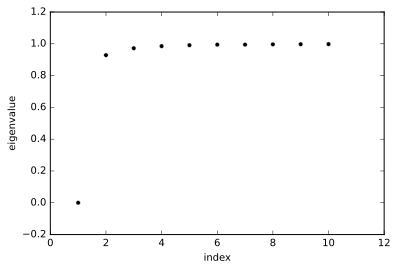

In [10]:
C.PlotEigengap()

For many datasets, you may want to consider other factors, e.g. choosing a minimum number of clusters, whether or not the eigengap reflects this.

Here we have chosen 3 as the optimal number of clusters.

In [11]:
C.Cluster(n_clusters=3)

performing spectral clustering on dot products...
    done.


We can now visualize clusters using spectral embedding.

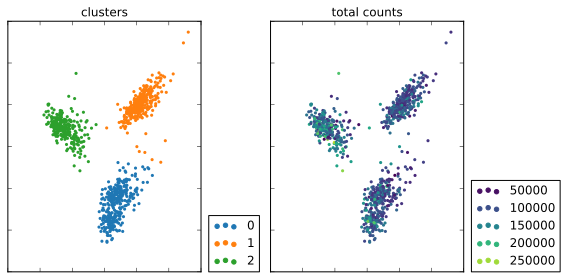

In [12]:
C.PlotEmbedding()

## Subsampling data

Cells are not sequenced to standard sequencing depth. This is sometimes a problem for downstream comparisons, but not always.

You can create an alternative count matrix where cells have an equal number of counts using the function `C.Subsample()`. To subsample to the minimum number of total counts across cells, use `cell_counts='min'`, otherwise the number of counts must be larger than the minimum value.

This matrix is stored in `C.subsample`

In [13]:
C.Subsample(cell_counts='min')

subsampling all cells to a standard sequencing depth of 40152


Similarly, there is often substantial heterogeneity in the magnitude of expression across genes. This may result in highly expressed genes having an outsized impact on results.

You can create an alternate count matrix where gene expression is bounded at a maximum total counts across cells, use `C.Subsample(gene_counts=[maximum]`. An example maximum value might be equal to 10x the number of cells (columns in the count matrix). 

In [14]:
# the following will overwrite our previous subsampled matrix 
C.Subsample(gene_counts=10*C.counts.shape[0]) 

# to subsample both genes and cells, 
# use gene_counts and cell_counts in the same function. 
# Genes will be subsampled first.

# C <- Subsample(C,gene_counts=10*C.counts.shape[0],cell_counts='min')

subsampling 1592 genes to a max total counts of 9250


## Subsetting data

You can filter the count matrix to only certain cells and genes using `C.SubsetCells()` and `C.SubsetGenes()`.

In [15]:
filter_cells = np.array(C.cell_scores['n_features'] < 8500) # cells with fewer than 8,500 unique genes observed
C.SubsetCells(filter_cells,remove_empty=False)

Number of genes: 29212
Number of cells: 463


In [16]:
filter_genes = (np.sum(C.counts,0) > 100) # genes that were observed
C.SubsetGenes(filter_genes,remove_empty=False)

Number of genes: 11569
Number of cells: 463


With `countland`, such data filtering may not be necessary or helpful. The original count matrix can be restored at any time.

In [17]:
C.RestoreCounts()

Number of genes: 29212
Number of cells: 925


## Identify marker genes

What makes a gene an ideal marker for a cluster may depend on downstream applications. For example, the ideal marker gene might be defined as the gene detected in all cells in a given cluster and none of the rest.

Under this definition, the top marker gene for each cluster can be identified by counting and comparing the number of non-zero cells.

In [18]:
C.RankMarkerGenes(method='prop-zero',subsample=False)
gdf = C.marker_genes.loc[(C.marker_genes['cluster_label'] == 1)]
gdf

,diff. proportion zero,rank,gene index,gene names,cluster_label
20834,0.909637,1,20834,ENSG00000182636,1
28461,0.901359,2,28461,ENSG00000100234,1
12263,0.897088,3,12263,ENSG00000169083,1
9427,0.895128,4,9427,ENSG00000229391,1
19480,0.890945,5,19480,ENSG00000120675,1
16457,0.889573,6,16457,ENSG00000149557,1
6135,0.887526,7,6135,ENSG00000121858,1
3112,0.883843,8,3112,ENSG00000158089,1
20689,0.878768,9,20689,ENSG00000214548,1
9430,0.871841,10,9430,ENSG00000179344,1


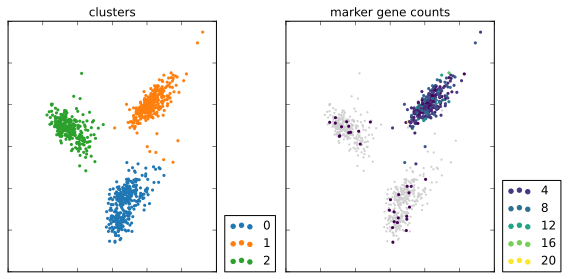

In [19]:
gene_index = gdf.loc[(gdf['cluster_label'] == 1) & (gdf['rank'] == 1)]['gene index'].values
C.PlotMarker(gene_index)

Alternatively, the top marker genes for each cluster can be identified by ranking genes according to differential gene expression, calculated using the Wilcoxon rank-sum statistic.

When calculating differential gene expression, it typically makes sense to subsample cells to a standard sequencing depth.

**Note this can take some time.**

In [20]:
C.Subsample(cell_counts="min")
C.RankMarkerGenes(method='rank-sums',subsample=True)
gdf = C.marker_genes.loc[(C.marker_genes['cluster_label'] == 1)]
gdf

subsampling all cells to a standard sequencing depth of 40152


,test-statistic,p-value,adjusted-p-value,significant diff.,rank,gene index,gene names,cluster_label
9286,193151.0,4.753483e-137,4.084081e-134,True,1,9286,ENSG00000206503,1
9356,193127.5,4.187782e-137,3.707075e-134,True,2,9356,ENSG00000204525,1
8645,192926.0,2.261451e-140,2.202050e-137,True,3,8645,ENSG00000019582,1
14633,192896.0,5.815108e-137,4.853455e-134,True,4,14633,ENSG00000106853,1
22925,192838.0,4.760705e-136,3.863047e-133,True,5,22925,ENSG00000181019,1
9428,192605.0,3.607361e-160,1.756304e-156,True,6,9428,ENSG00000196126,1
21128,192527.0,3.797257e-135,2.919091e-132,True,7,21128,ENSG00000166710,1
27362,192357.0,1.178162e-135,9.301750e-133,True,8,27362,ENSG00000090013,1
9357,192338.0,8.760213e-135,6.092937e-132,True,9,9357,ENSG00000234745,1
9424,192268.5,1.481116e-149,2.403686e-146,True,10,9424,ENSG00000204287,1


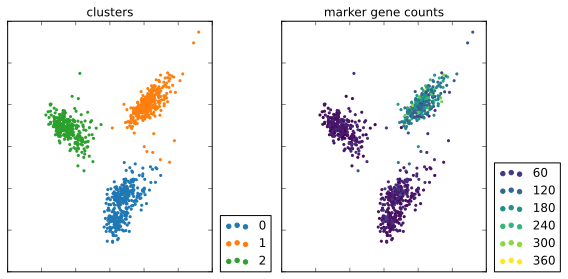

In [21]:
gene_index = gdf.loc[(gdf['cluster_label'] == 1) & (gdf['rank'] == 1)]['gene index'].values 
C.PlotMarker(gene_index)